In [29]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import trange, tqdm
import joblib
import matplotlib.pyplot as plt
import math


In [30]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out

# Define custom dataset
class PacketCaptureDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [31]:
def regression_through_origin_with_correlation(x, y):
    """
    Calculate the slope of the regression line that goes through the origin
    for the given data points (x, y) and return the correlation coefficient.
    
    Parameters:
    x (array-like): Array of predictor values.
    y (array-like): Array of response values.
    
    Returns:
    tuple: The slope of the regression line through the origin and the correlation coefficient.
    """
    # Reshape x to be a 2D array with one column (required by lstsq)
    x_reshaped = np.array(x).reshape(-1, 1)
    y = np.array(y)
    
    # Use lstsq to fit a line through the origin
    m, _, _, _ = np.linalg.lstsq(x_reshaped, y, rcond=None)
    
    # m contains the slope of the line through the origin
    slope = m[0]
    
    # Calculate the predicted y values using the slope
    y_pred = slope * x
    
    # Calculate the correlation coefficient
    correlation_matrix = np.corrcoef(y, y_pred)
    correlation_coefficient = correlation_matrix[0, 1]
    
    return correlation_coefficient, slope

In [32]:
def normalized_slope(slope):
    return math.exp(-abs(math.log10(slope)))

def standard_metric(correlation_coef, slope):
    return normalized_slope(slope) * correlation_coef

10s_1s
Slope: 0.5093179941177368, Correlation Coefficient: 0.5390517374729409, Standard Metric: 0.40214011561223995
abs errors
[1.14691296e+01 4.64083481e+01 4.91652222e+02 6.15242004e-01
 2.03030205e+00 3.45454216e+00 4.88022614e+00 1.94015312e+00
 1.23243332e+00 9.41732025e+00 2.19558830e+01 1.68460312e+02
 1.06471443e+00 1.73757111e+02 3.08510208e+00 7.34344101e+00
 1.89427719e+01 9.65631485e+00 2.29031754e+00 1.10924320e+01
 9.22223091e+00 3.82173424e+01 1.64600372e+00 1.67846107e+00
 7.05339813e+00 1.61650276e+00 4.34618378e+00 1.07677460e+00
 7.10609192e+02 1.57208252e+00 8.62819672e+00 1.22752953e+00
 2.82449799e+01 2.04189606e+01 9.42618942e+00 1.04791126e+01
 3.99346466e+01 9.39735603e+00 2.66702080e+00 3.01955605e+00
 9.61474037e+00 9.30997849e-01 2.41254044e+00 5.43313408e+00
 3.61162376e+00 7.30993271e+00 2.56329536e+00 2.53676414e+00
 5.31094170e+00 1.79408665e+01 2.77612305e+00 7.64229279e+01
 1.53360157e+01 2.58026123e-01 2.95679092e-01 2.98770180e+01
 1.16851463e+01 5.0

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


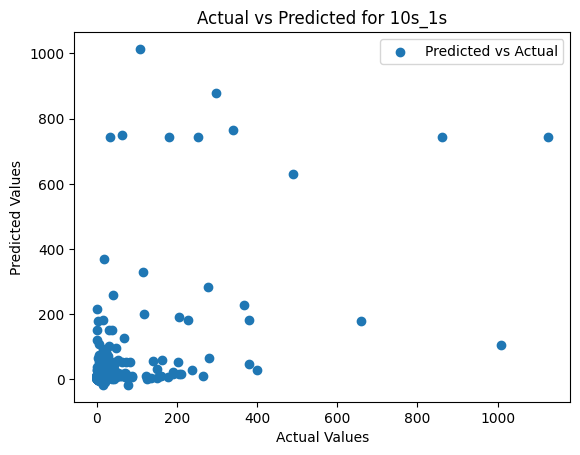

Slope: 0.509318
Correlation Coefficient: 0.5390517374729409
Standard metric for 10s_1s: 0.40214011561223995
Standard metric 98th percentile for 10s_1s: 0.7217257443552162
10s_5s
Slope: 0.37500137090682983, Correlation Coefficient: 0.049829602631498125, Standard Metric: 0.032545597080975215
abs errors
[2.30487823e+01 2.36381073e+01 1.79686127e+01 1.11265259e+01
 2.40286652e+02 1.08396683e+01 2.96065655e+01 9.66561699e+00
 3.72542953e+00 9.18937111e+00 8.93372536e+00 3.04982147e+01
 1.42332336e+02 1.99441032e+01 1.76515427e+01 2.93666992e+01
 2.89651031e+01 2.99636917e+01 2.52642670e+01 2.48933296e+01
 2.83991890e+01 2.83116188e+01 2.83510723e+01 1.15727730e+01
 9.17372131e+00 2.86202831e+01 3.03327351e+01 2.92986526e+01
 8.37514877e+00 1.11366596e+01 1.85322571e+01 8.59162903e+00
 7.96831512e+00 1.20412941e+01 6.10351372e+00 2.25125103e+01
 1.57317066e+01 2.00843124e+01 2.04901180e+01 2.67585392e+01
 1.59985828e+01 2.24650669e+00 2.87405567e+01 1.74607239e+01
 2.69551983e+01 9.66101265e

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


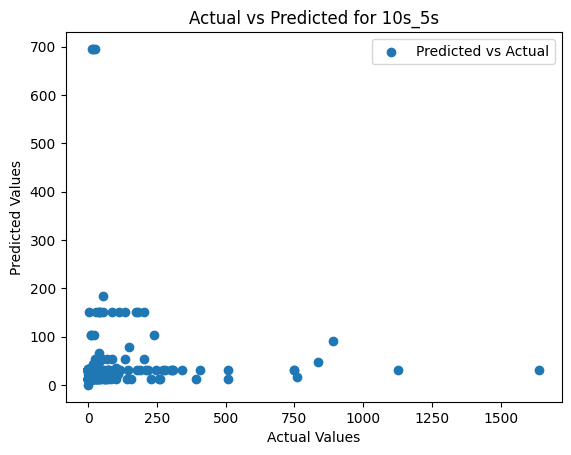

Slope: 0.37500137
Correlation Coefficient: 0.049829602631498125
Standard metric for 10s_5s: 0.032545597080975215
Standard metric 98th percentile for 10s_5s: 0.3518622612408343
5s_0.01s
Slope: 0.6872128844261169, Correlation Coefficient: 0.39292962396391035, Standard Metric: 0.3338600240141851
abs errors
[1.46879387e+00 5.07411270e+01 5.65205956e+00 6.86947250e+01
 1.98758469e+01 9.17530251e+00 9.99560547e+00 4.44990540e+00
 1.21282578e-01 3.30758476e+00 4.72322464e-01 4.50205109e+02
 1.27510452e+00 4.47194481e+00 8.58415604e-01 1.77840805e+00
 1.59999847e-01 1.38866425e-01 5.68588257e-01 6.88930511e-01
 7.89440552e+02 3.64112854e-02 8.66242218e+00 1.24913788e+00
 5.51319122e-02 5.19035435e+00 7.13415146e-01 6.40241623e-01
 1.78090096e+01 1.20659637e+00 2.40568848e+01 6.49263382e-01
 2.81273460e+00 1.53783035e+00 8.81603241e-01 4.41284180e-01
 1.19904518e+00 2.04228592e+00 8.89564514e-01 1.41840801e+01
 1.29050018e+02 3.54711975e+02 9.61063385e-01 1.19926643e+00
 2.81368446e+00 8.864355

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


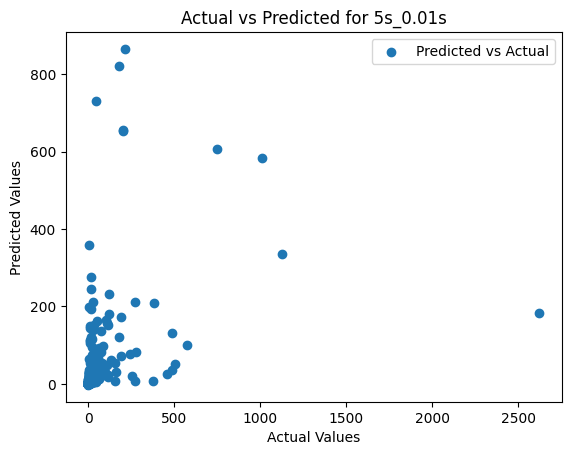

Slope: 0.6872129
Correlation Coefficient: 0.39292962396391035
Standard metric for 5s_0.01s: 0.3338600240141851
Standard metric 98th percentile for 5s_0.01s: 0.6013004284511485
5s_0.05s
Slope: 0.5326088666915894, Correlation Coefficient: 0.32866996040866475, Standard Metric: 0.25000039042521377
abs errors
[2.23026085e+00 1.27111759e+01 3.65912628e+00 2.73388481e+00
 2.91635323e+00 2.53025055e+00 1.54684258e+00 1.16827774e+00
 1.26291561e+01 2.69837761e+00 3.11004448e+00 1.47039604e+00
 1.58554077e-01 7.18307495e-01 3.01285362e+00 2.08096294e+01
 1.62195301e+00 1.35670853e+00 1.29631863e+01 6.46341476e+01
 2.46433105e+01 3.91370773e+00 1.62252045e+00 2.59801865e+00
 1.19887543e+00 4.75603104e-01 1.40296555e+00 7.94649887e+00
 1.80389214e+00 2.65813110e+02 3.93919563e+00 1.97909737e+00
 8.33625603e+00 1.91636276e+00 1.46612740e+00 1.30570412e+00
 1.12366867e+01 7.03592300e-01 1.84690094e+00 2.12155342e+00
 1.20806503e+00 3.27064514e+00 6.04689407e+00 8.32918167e-01
 6.18062401e+01 1.70814

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


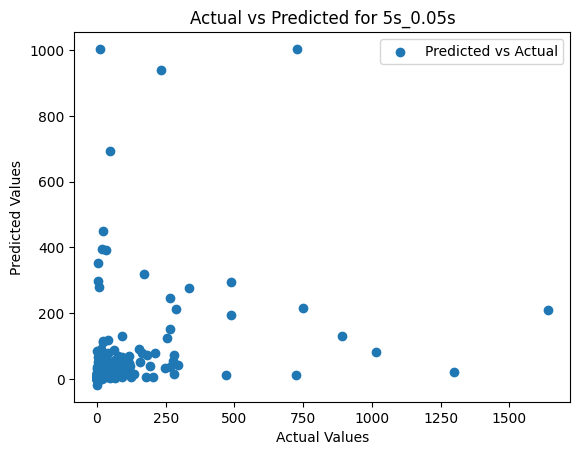

Slope: 0.53260887
Correlation Coefficient: 0.32866996040866475
Standard metric for 5s_0.05s: 0.25000039042521377
Standard metric 98th percentile for 5s_0.05s: 0.6392067763543814
10s_1s_complex
15s_0.2s
Slope: 0.0018554668640717864, Correlation Coefficient: 0.2861008956306704, Standard Metric: 0.018630457349902547
abs errors
[2.58579010e+02 2.03424646e+03 3.18204498e+01 2.29828613e+02
 1.28354883e+03 8.39340149e+02 1.91795801e+03 1.44495837e+03
 5.91281311e+02 1.07550415e+03 3.23065979e+02 3.34299042e+02
 5.14309692e+01 6.78825562e+02 2.21023950e+03 1.13145605e+03
 3.59823608e+02 5.59104370e+02 3.49569678e+03 8.02482758e+01
 4.31692169e+02 3.76972876e+03 2.29825513e+03 2.19623093e+02
 4.68727246e+03 1.12014429e+03 3.25741119e+02 5.75403027e+03
 3.36716217e+02 1.24386743e+03 1.53929663e+03 4.60186249e+02
 1.36841052e+03 4.55062103e+02 6.71269989e+00 3.00621399e+02
 6.83174658e+03 4.25058203e+03 1.14212173e+02 5.12183228e+02
 3.24511719e+02 1.62970969e+05 3.78459503e+02 3.11129944e+02
 1.

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


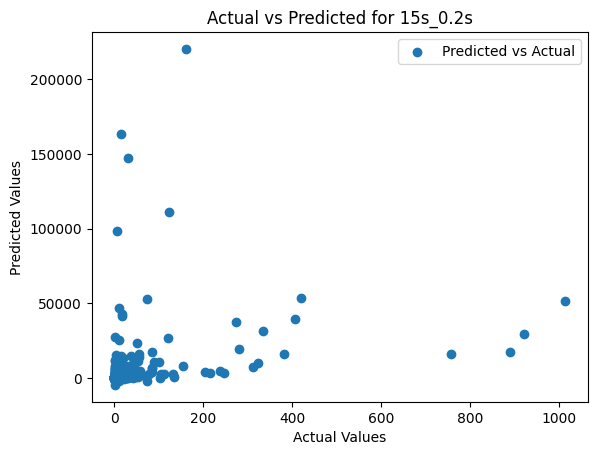

Slope: 0.0018554669
Correlation Coefficient: 0.2861008956306704
Standard metric for 15s_0.2s: 0.018630457349902547
Standard metric 98th percentile for 15s_0.2s: 0.007733514796458476
2.5s_0.05s
Slope: 0.6170313954353333, Correlation Coefficient: 0.30835107126618294, Standard Metric: 0.25002133087867146
abs errors
[3.07495308e+00 3.87549210e+00 1.64678192e+00 1.92278481e+00
 2.41557121e+00 5.12240791e+00 1.86089516e+00 9.83403683e+00
 3.53097916e+00 4.04774666e+00 8.44715118e-01 2.45356750e+00
 3.21468124e+01 3.87473869e+00 9.36735344e+00 1.90034866e-01
 4.26534081e+00 1.30979919e+00 4.72570038e+00 5.01202202e+00
 1.01689873e+01 9.17850494e-01 4.67059517e+00 1.57130661e+01
 1.77838135e+00 5.11338997e+00 2.14759445e+00 1.72207108e+02
 2.53810730e+01 1.61518402e+01 1.49693298e+00 4.00685310e+00
 4.17917252e-01 2.25287457e+01 6.16121292e+00 1.17592049e+00
 9.08191681e-01 1.55387497e+00 5.60317993e-01 2.02472401e+01
 2.00824585e+01 4.97129135e+01 4.07368279e+00 3.04733276e-01
 7.46330452e+00

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


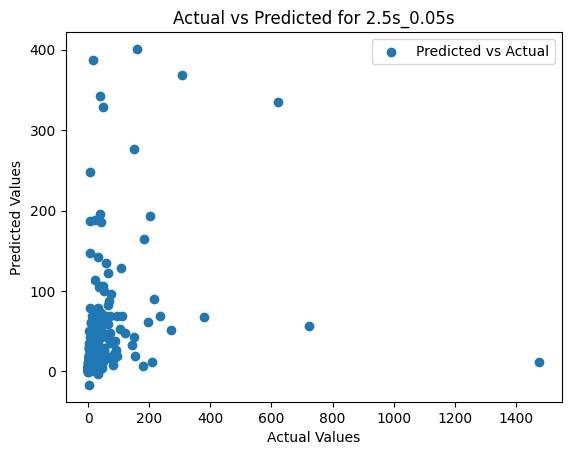

Slope: 0.6170314
Correlation Coefficient: 0.30835107126618294
Standard metric for 2.5s_0.05s: 0.25002133087867146
Standard metric 98th percentile for 2.5s_0.05s: 0.5695370110073358
1s_0.05s
Slope: 0.5145343542098999, Correlation Coefficient: 0.39915073404877205, Standard Metric: 0.29909268300849334
abs errors
[1.06103516e+00 6.00263405e+00 1.94514084e+00 6.10484375e+02
 1.15627838e+02 6.79475594e+00 1.51532555e+00 3.42388535e+00
 1.50495195e+01 5.55637451e+02 1.24565887e+00 5.15606880e+00
 1.18667698e+01 1.02479277e+01 4.90020752e-01 1.16890526e+00
 2.47659111e+00 3.43778229e+00 3.13282013e-02 4.40007324e+01
 1.07750511e+00 1.99529648e+01 8.66364288e+00 6.93677902e+00
 4.60045815e+00 3.73762321e+00 6.43045807e+00 3.05694199e+00
 1.16099796e+01 7.85881042e-01 1.42968559e+00 2.97160034e+01
 6.46061096e+01 1.27151680e+00 1.59349060e+00 4.10496902e+00
 1.00916100e+01 1.98582649e+00 1.99882050e+01 4.72563133e+01
 8.42641830e-01 4.81947899e+00 5.75713730e+00 3.62922478e+00
 7.31176186e+00 3.

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


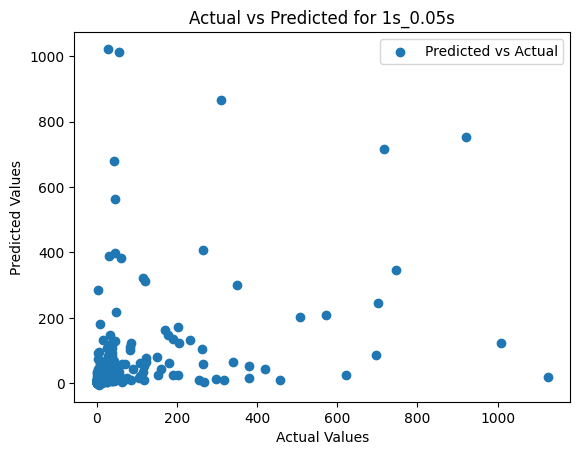

Slope: 0.51453435
Correlation Coefficient: 0.39915073404877205
Standard metric for 1s_0.05s: 0.29909268300849334
Standard metric 98th percentile for 1s_0.05s: 0.7004458228635188
10s_5s_complex
7.5s_0.05s
Slope: 0.7417254447937012, Correlation Coefficient: 0.45705338673729157, Standard Metric: 0.4014340985259623
abs errors
[2.11333466e+00 3.11995506e+00 1.14531326e+00 2.86306572e+00
 1.75905991e+00 2.99415398e+00 3.27326965e+00 1.73497581e+00
 3.38528061e+00 5.99882889e+00 1.35210037e-01 5.44579124e+00
 1.69111958e+01 1.40768242e+00 1.04406290e+01 2.74901962e+00
 9.41896248e+00 1.02085991e+01 2.59496307e+00 4.42974854e+00
 7.95761490e+00 9.15824699e+00 1.21496010e+00 1.03000736e+01
 3.65959549e+00 3.95427322e+00 1.76599121e+00 2.11763573e+00
 2.42289925e+00 5.95232010e-01 1.22844372e+01 1.14272797e+02
 1.38803177e+01 6.95840263e+00 7.60959148e+00 3.87079811e+00
 2.49894600e+01 6.52094269e+01 2.32431793e+00 5.64694595e+00
 5.50833511e+00 8.25134201e+01 2.03171539e+00 2.93015671e+00
 4.92

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


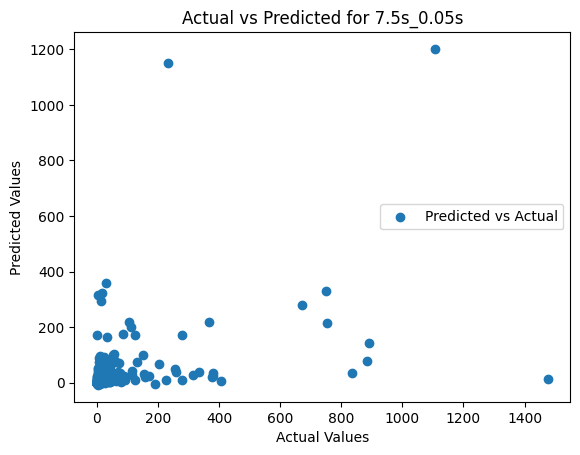

Slope: 0.74172544
Correlation Coefficient: 0.45705338673729157
Standard metric for 7.5s_0.05s: 0.4014340985259623
Standard metric 98th percentile for 7.5s_0.05s: 0.6636487549241542
15s_0.05s
Slope: 0.6513881087303162, Correlation Coefficient: 0.3623544384661019, Standard Metric: 0.3008051373027533
abs errors
[4.47485352e+00 1.31458664e+00 3.61530304e-01 1.13883829e+01
 4.23315620e+00 1.05970116e+01 2.95771698e+02 1.25819122e+02
 4.20642853e-01 1.85327530e-01 8.27167511e-01 2.07508850e+00
 5.77348900e+00 2.35626221e-01 8.53162766e-01 4.22857895e+01
 6.62345505e+00 1.24018669e+00 3.93079758e-01 9.28384781e-01
 1.23668652e+01 8.10103226e+00 1.51659145e+01 8.11244965e-01
 8.90371323e-01 1.33248711e+00 1.24044609e+00 1.99615143e+02
 8.93869400e-01 3.80814552e+00 4.01765594e+01 2.08048248e+00
 3.52190018e+01 5.69807053e-01 1.26117268e+01 9.67508316e-01
 3.11520767e+00 1.05283737e-01 2.52608490e+00 5.65644646e+00
 9.70299816e+00 1.10150887e+02 2.42112610e+02 1.82417965e+01
 6.11162186e-01 4.0

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


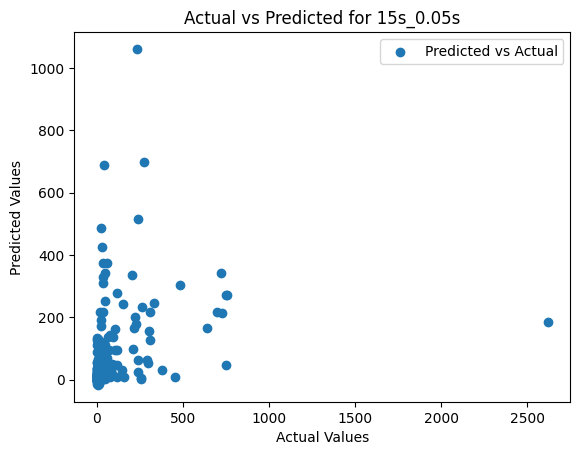

Slope: 0.6513881
Correlation Coefficient: 0.3623544384661019
Standard metric for 15s_0.05s: 0.3008051373027533
Standard metric 98th percentile for 15s_0.05s: 0.4702763117990135
2.5s_0.01s
Slope: 0.8175927996635437, Correlation Coefficient: 0.31034161012729694, Standard Metric: 0.2843513771791172
abs errors
[3.63395691e-01 1.62631226e+01 2.90033340e-01 1.70809841e+01
 8.29080391e+00 7.71005821e+00 5.73585510e-01 1.41834641e+00
 2.19252625e+01 1.55505524e+01 5.39300919e-01 1.15276337e+00
 1.30161667e+00 1.10437994e+01 4.52949715e+00 4.35381317e+00
 4.34455872e-01 9.81729507e-01 2.35685539e+00 2.83355713e-01
 1.16730232e+01 3.93049240e-01 2.27992058e+00 1.60851097e+00
 6.75669098e+00 1.42552185e+00 1.92493439e-01 2.56645393e+00
 1.15177155e-01 3.42795258e+01 2.17393875e-01 2.14009094e+01
 5.61497192e+01 4.60493088e-01 4.60370445e+00 2.68278122e-01
 2.12001801e-02 4.22510147e-01 7.56851044e+01 3.34524155e-01
 5.72368050e+00 5.68758392e+00 2.44993805e+02 5.66778183e-01
 1.58020020e-01 1.176

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


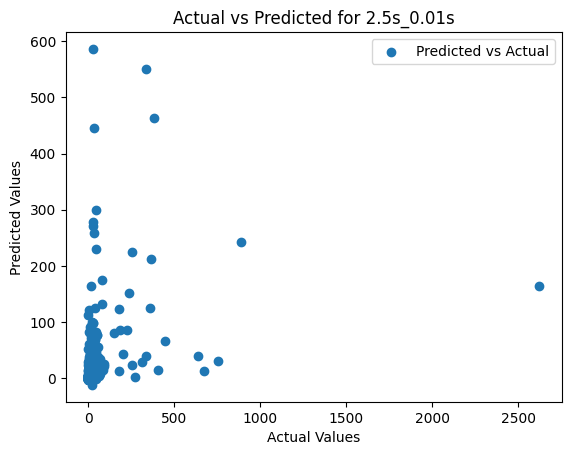

Slope: 0.8175928
Correlation Coefficient: 0.31034161012729694
Standard metric for 2.5s_0.01s: 0.2843513771791172
Standard metric 98th percentile for 2.5s_0.01s: 0.5201499127932799
5s_0.2s
Slope: 0.2261369526386261, Correlation Coefficient: 0.22272304203161264, Standard Metric: 0.11678102161697038
abs errors
[2.02350616e-01 7.95169449e+00 6.20243454e+00 5.87819061e+01
 1.07412815e+01 4.54505920e-01 4.79393196e+00 3.11222115e+01
 6.16477776e+00 2.70341873e-01 8.89076233e-01 3.64160538e-01
 5.70323944e-01 9.30498123e-01 6.79819107e-01 3.49082947e+00
 1.15885677e+01 1.95406532e+00 4.54237747e+00 1.46786308e+00
 6.95411682e+00 4.39558624e+02 2.52274895e+00 2.49534035e+00
 1.11317917e+02 1.10160248e+02 2.35855865e+00 8.00403786e+00
 9.07007217e-01 1.71925411e+01 3.40538788e+00 2.40169296e+01
 4.01634789e+00 3.20673370e+00 7.33082771e+00 9.06039963e+01
 1.54968739e+01 8.64137650e-01 7.65438080e-01 6.95711136e-01
 2.07617188e+00 5.40396118e+00 2.62665939e+00 2.75116348e+00
 1.40339088e+00 1.09

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


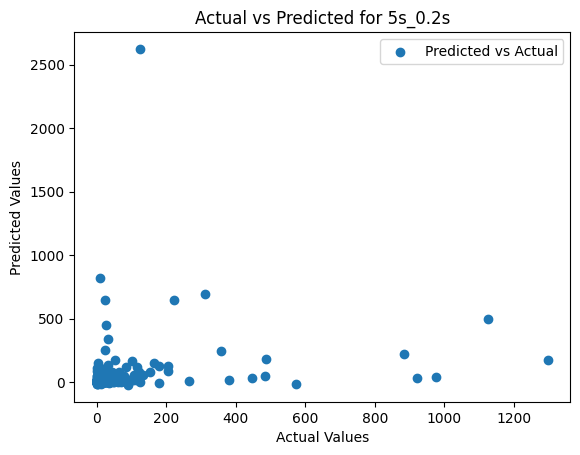

Slope: 0.22613695
Correlation Coefficient: 0.22272304203161264
Standard metric for 5s_0.2s: 0.11678102161697038
Standard metric 98th percentile for 5s_0.2s: 0.4547631846076375
1s_0.01s
Slope: 0.5069129467010498, Correlation Coefficient: 0.3144286042388682, Standard Metric: 0.2340864332898761
abs errors
[1.76923370e+00 1.69014740e+01 4.69225693e+00 1.66534233e+00
 9.15241623e+00 6.08136597e+01 1.73490562e+01 8.71461487e+00
 2.20353947e+01 4.12042618e-01 6.45994186e-01 3.64012146e+00
 5.78030014e+00 1.36204300e+01 2.85254860e+00 2.82909027e+02
 5.03871918e-01 2.11366272e+00 1.22545166e+01 8.66829109e+00
 3.34411812e+01 2.22633553e+00 5.79040909e+00 1.77698708e+00
 1.96242142e+00 5.52414703e+00 1.63837605e+01 7.90042877e-02
 1.17101402e+01 2.31223488e+00 1.83560944e+00 1.25322914e+00
 2.49012184e+00 1.84901237e+00 1.77349854e+00 2.13241577e+00
 8.02553558e+00 1.51841164e+00 4.82818222e+00 1.51293755e+00
 1.80893135e+00 5.56498718e+00 1.42252922e+00 1.58858109e+00
 1.65048409e+00 6.2823455

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


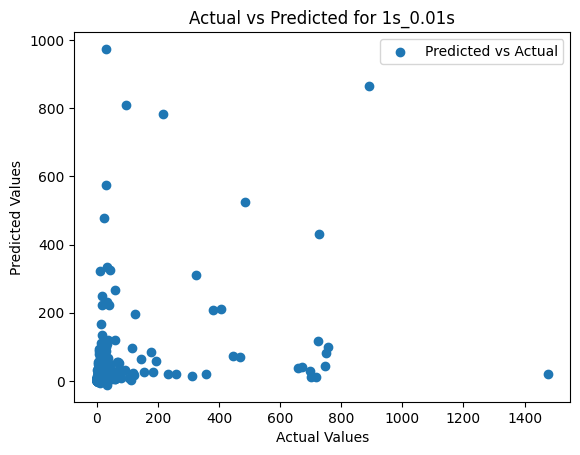

Slope: 0.50691295
Correlation Coefficient: 0.3144286042388682
Standard metric for 1s_0.01s: 0.2340864332898761
Standard metric 98th percentile for 1s_0.01s: 0.4895617679318036
10s_0.05s
Slope: 0.9026119709014893, Correlation Coefficient: 0.4304671044307965, Standard Metric: 0.41173173043042127
abs errors
[3.81732559e+00 5.97029114e+00 1.42110252e+00 1.02173805e+00
 1.22849602e+02 1.23969078e+00 5.14573288e+00 1.24704605e+02
 5.82782745e-01 8.84670258e-01 4.72241211e+00 1.47861099e+00
 4.05858994e-01 1.81932037e+02 1.58667068e+01 3.13196316e+01
 4.96437263e+00 2.89297104e-01 2.29503632e-01 1.90314674e+00
 4.88930511e+00 8.77403259e-01 1.18680763e+00 1.98349380e+00
 3.50938797e+00 6.42911911e+00 4.82219696e-01 9.87052917e-01
 1.27013397e+00 1.84896469e-01 1.48154068e+01 5.78048706e-01
 1.42175407e+01 1.33807182e+00 1.03313446e-01 9.12146606e+01
 1.97891617e+00 4.88490486e+00 5.99218941e+00 1.70396442e+01
 6.96920395e-01 9.42161560e-01 3.00224686e+00 3.51004028e+00
 2.75899261e+02 2.12584

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


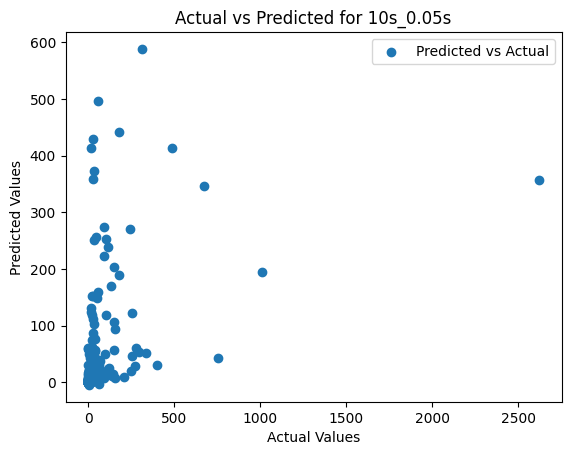

Slope: 0.902612
Correlation Coefficient: 0.4304671044307965
Standard metric for 10s_0.05s: 0.41173173043042127
Standard metric 98th percentile for 10s_0.05s: 0.5290129572430746
1s_0.2s
Slope: 0.7151714563369751, Correlation Coefficient: 0.3058364063499953, Standard Metric: 0.2643993136115776
abs errors
[1.10504150e-01 7.70583916e+00 1.93769264e+00 6.03265953e+00
 3.66962242e+00 1.46781387e+01 6.20455742e+00 1.85005875e+01
 8.64938927e+00 1.06117134e+01 5.22223473e+00 5.58661461e+00
 1.62929108e+02 4.75200653e+00 4.84664726e+00 1.17071991e+02
 1.52192497e+00 7.39064407e+00 7.42852783e+00 1.42166348e+01
 5.33274841e+00 1.42408323e+01 4.42456474e+01 7.27409744e+00
 1.09089108e+01 3.58264694e+01 8.68163300e+00 4.04756042e+02
 7.75984726e+01 4.33362923e+01 1.83405876e+00 1.55099854e+02
 4.12343407e+00 9.08597946e-01 1.62286949e+01 1.42668266e+01
 3.31282806e+01 5.10935059e+01 4.26922417e+01 1.63330841e+00
 2.80727463e+01 1.42416029e+01 7.41332436e+00 1.00347071e+01
 9.77763939e+00 6.3570852

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


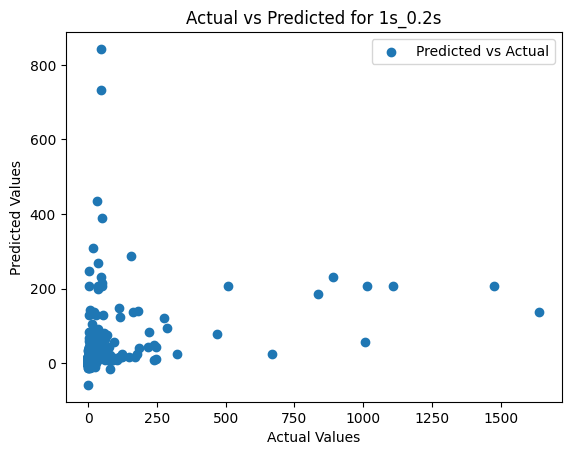

Slope: 0.71517146
Correlation Coefficient: 0.3058364063499953
Standard metric for 1s_0.2s: 0.2643993136115776
Standard metric 98th percentile for 1s_0.2s: 0.29716742661295936
7.5s_0.01s
Slope: 0.9524252414703369, Correlation Coefficient: 0.6067067867699474, Standard Metric: 0.5939983359617004
abs errors
[2.72922516e-02 5.59635162e-02 6.52393341e-01 2.34168816e+00
 1.95263290e+00 7.51979828e+00 5.03045959e+01 6.64208221e+00
 3.74498558e+00 2.24081039e-01 1.31133423e+01 1.98281708e+01
 1.35504532e+00 4.37454376e+01 8.29095383e+01 6.60517693e+00
 2.76723289e+01 9.32081985e+00 2.48849411e+01 2.94871712e+00
 2.10660362e+00 5.02016830e+01 3.36822266e+02 6.54097748e+00
 1.38710022e+00 9.37427521e+00 1.00948334e+00 5.31328735e+02
 5.84651947e-01 5.78048420e+00 3.98027420e-01 8.25658798e+00
 1.98102951e-01 7.90614605e+00 2.35723495e-01 9.65653610e+00
 8.57715607e-01 4.11417007e-01 1.00704605e+02 6.52000427e-01
 1.95310593e-01 9.45014954e-02 1.82368164e+01 1.31683655e+01
 3.07254410e+00 1.459911

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


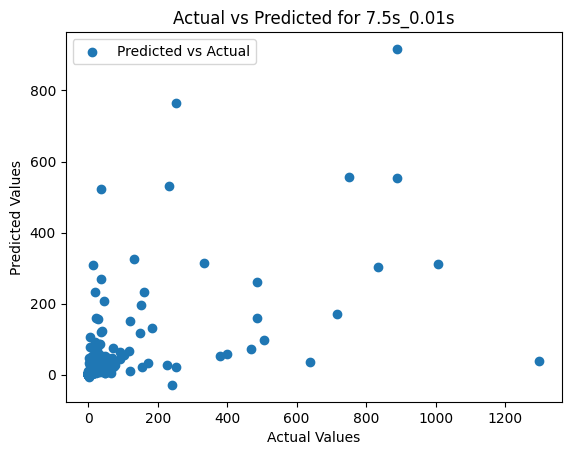

Slope: 0.95242524
Correlation Coefficient: 0.6067067867699474
Standard metric for 7.5s_0.01s: 0.5939983359617004
Standard metric 98th percentile for 7.5s_0.01s: 0.7676410212299567
10s_0.2s
Slope: 0.6482240557670593, Correlation Coefficient: 0.5479387188253103, Standard Metric: 0.4539053052370457
abs errors
[1.42368507e+01 1.02461586e+01 3.74428558e+00 1.18135452e-01
 7.46711731e-01 6.00870132e-01 5.07837105e+00 1.58864021e+00
 5.84634247e+01 1.14479198e+01 1.02217598e+01 1.12495422e-01
 8.06419373e-01 4.41030312e+00 1.51774788e+00 7.94231606e+00
 5.03210068e-01 1.18212730e+02 1.60440445e+00 1.16625404e+00
 5.00664429e+02 5.59436226e+00 3.99445343e+01 8.36931992e+00
 1.43163681e+00 1.01121330e+00 2.65247345e+00 1.74321766e+01
 2.31946945e-01 1.14565430e+01 7.95536041e-01 3.12352562e+00
 2.98492622e+00 9.48400307e+00 1.85395241e+00 2.43662434e+01
 3.19295883e+00 5.93109131e-01 9.02402878e-01 4.54196358e+01
 9.01146507e+00 4.97821999e+00 3.70390282e+01 7.51164818e+00
 2.52062416e+00 5.741

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


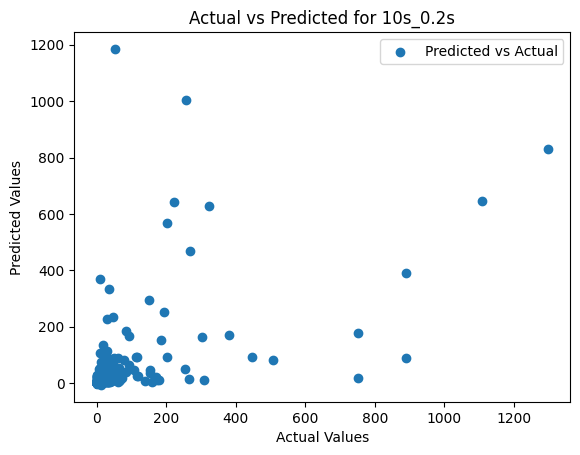

Slope: 0.64822406
Correlation Coefficient: 0.5479387188253103
Standard metric for 10s_0.2s: 0.4539053052370457
Standard metric 98th percentile for 10s_0.2s: 0.5054631124232777
10s_0.01s
Slope: 1.2177625894546509, Correlation Coefficient: 0.6918167811372669, Standard Metric: 0.6350847949515244
abs errors
[1.87661800e+01 6.65569496e+00 1.59986172e+01 1.60099220e+00
 1.27575684e+00 1.97733116e+00 8.04056168e-01 1.69069481e+00
 4.36363220e-01 2.84442902e-01 1.68231010e+00 3.95503998e-01
 7.84721375e-01 4.09351158e+00 3.19956909e+02 5.80226990e+02
 4.35700531e+01 1.85800552e+00 1.04553604e+00 2.25237656e+00
 2.65580177e+00 7.19303513e+00 2.38754272e-01 9.26307678e-01
 4.40294037e+01 3.29706383e+00 1.93801365e+01 3.19226646e+00
 1.98937759e+01 3.36160851e+00 4.18987885e+01 8.94149780e-01
 2.94446945e-01 1.01962137e+01 1.60897125e+02 1.94683151e+01
 1.33922768e+00 1.69005775e+00 1.01432747e+02 1.84795952e+00
 3.22618484e-01 1.64720345e+00 8.40822983e+00 3.36111145e+01
 1.15609550e+00 4.967460

/tmp/ipykernel_11893/180596917.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


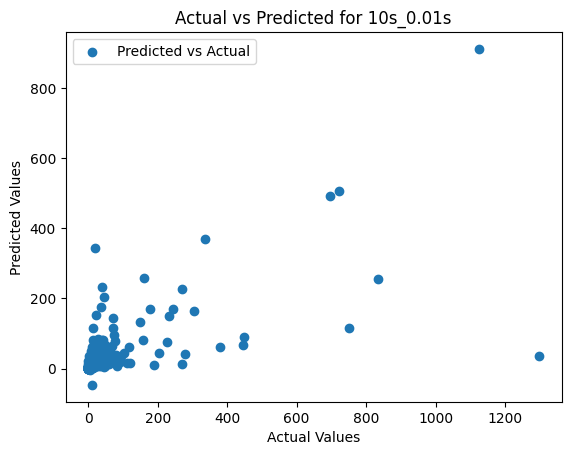

Slope: 1.2177626
Correlation Coefficient: 0.6918167811372669
Standard metric for 10s_0.01s: 0.6350847949515244
Standard metric 98th percentile for 10s_0.01s: 0.7205317477217975


In [33]:
# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=[
    'model_name', 'total', 'delta', 'slope', 'correlation_coef', 'standard_metric', 
    'avg_abs_error', 'avg_abs_error_normalized', 'median_abs_error', 
    'median_abs_error_normalized', '98th_abs_error', '98th_avg_abs_error','98th_abs_error_normalized', '98th_avg_abs_error_normalized',
    'slope_98th', 'correlation_coef_98th', 'standard_metric_98th', 
])

# Iterate over each file in the directory ../model/models
for filename in os.listdir('../model/models'):
    model_name = filename[14:-3]
    print(model_name)

    if 'complex' in model_name or not filename.endswith('.pt'):
        continue

    x, y = model_name.split('_')
    total = float(x[:-1])
    delta = float(y[:-1])

    data_tensors = torch.load(f'../model/data/data_tensors_{model_name}.pt')
    target_tensors = torch.load(f'../model/data/target_tensors_{model_name}.pt')

    # Normalize the target tensors
    target_mean = target_tensors.mean()
    target_std = target_tensors.std()

    def denormalize(tensor):
        return tensor * target_std + target_mean

    target_tensors = (target_tensors - target_mean) / target_tensors.std()
    train_data, test_data, train_targets, test_targets = train_test_split(
        data_tensors, target_tensors, test_size=0.2, random_state=42
    )

    train_dataset = PacketCaptureDataset(train_data, train_targets)
    test_dataset = PacketCaptureDataset(test_data, test_targets)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    input_size = len(train_dataset[0][0][0])
    hidden_size = 64
    output_size = 1
    model = RNNModel(input_size, hidden_size, output_size)

    num_samples = len(test_targets)

    # Load the weights from this file
    model = RNNModel(input_size, hidden_size, output_size)
    model.load_state_dict(torch.load(f'../model/models/{filename}'))
    model.eval()

    with torch.no_grad():
        test_data_tensor = torch.stack([item[0] for item in test_dataset])
        test_targets_tensor = torch.stack([item[1] for item in test_dataset])
        
        pred = model(test_data_tensor).flatten()
        pred_denorm = denormalize(pred).numpy().flatten()
        targets_denorm = denormalize(test_targets_tensor).numpy().flatten()
        
        correlation_coef, slope = regression_through_origin_with_correlation(
            pred_denorm,
            targets_denorm
        )
    
    standard_metric_value = standard_metric(correlation_coef, slope)
    print(f'Slope: {slope}, Correlation Coefficient: {correlation_coef}, Standard Metric: {standard_metric_value}')

    abs_errors = torch.abs(denormalize(pred) - denormalize(test_targets_tensor)).numpy().flatten()
    print("abs errors")
    print(abs_errors)
    percent_abs_errors = abs_errors / denormalize(test_targets_tensor).numpy().flatten()
    print("percent abs errors")
    print(percent_abs_errors)

    avg_abs_error = np.mean(abs_errors)
    avg_abs_error_normalized = np.mean(percent_abs_errors)
    median_abs_error = np.median(abs_errors)
    median_abs_error_normalized = np.median(percent_abs_errors)
    percentile_98th = np.percentile(abs_errors, 98)
    percentile_98th_average = np.mean(abs_errors[abs_errors < percentile_98th])
    percentile_98th_normalized = np.percentile(percent_abs_errors, 98)
    percentile_98th_normalized_average = np.mean(percent_abs_errors[abs_errors < percentile_98th])

    # crop the pred_denorm, targets_denorm to only include values where the error of the prediction is within the 98th percentile
    print(pred.shape)
    print(test_targets_tensor.shape)
    print(pred_denorm.shape, targets_denorm.shape, abs_errors.shape)
    pred_denorm_98th = pred_denorm[abs_errors < percentile_98th]
    targets_denorm_98th = targets_denorm[abs_errors < percentile_98th]

    slope_98th, correlation_coef_98th = regression_through_origin_with_correlation(
        pred_denorm_98th,
        targets_denorm_98th
    )

    standard_metric_value_98th = standard_metric(correlation_coef_98th, slope_98th)


    results_df = results_df.append({
        'model_name': model_name,
        'total': total,
        'delta': delta,
        'slope': slope,
        'correlation_coef': correlation_coef,
        'standard_metric': standard_metric_value,
        'avg_abs_error': avg_abs_error,
        'avg_abs_error_normalized': avg_abs_error_normalized,
        'median_abs_error': median_abs_error,
        'median_abs_error_normalized': median_abs_error_normalized,
        '98th_abs_error': percentile_98th,
        '98th_avg_abs_error': percentile_98th_average,
        '98th_abs_error_normalized': percentile_98th_normalized,
        '98th_avg_abs_error_normalized': percentile_98th_average,
        'slope_98th': slope_98th,
        'correlation_coef_98th': correlation_coef_98th,
        'standard_metric_98th': standard_metric_value_98th
    }, ignore_index=True)

    # Plot actual vs predicted values
    plt.figure()
    plt.scatter(targets_denorm, pred_denorm, label='Predicted vs Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.legend()
    plt.show()

    # Print standard metric
    print("Slope: "+ str(slope))
    print("Correlation Coefficient: "+ str(correlation_coef))
    print(f'Standard metric for {model_name}: {standard_metric_value}')
    print(f'Standard metric 98th percentile for {model_name}: {standard_metric_value_98th}')

# Save the results to a CSV file if needed
results_df.to_csv('model_evaluation_results.csv', index=False)

In [34]:
print(results_df)

    model_name  total  delta     slope  correlation_coef  standard_metric  \
0       10s_1s   10.0   1.00  0.509318          0.539052         0.402140   
1       10s_5s   10.0   5.00  0.375001          0.049830         0.032546   
2     5s_0.01s    5.0   0.01  0.687213          0.392930         0.333860   
3     5s_0.05s    5.0   0.05  0.532609          0.328670         0.250000   
4     15s_0.2s   15.0   0.20  0.001855          0.286101         0.018630   
5   2.5s_0.05s    2.5   0.05  0.617031          0.308351         0.250021   
6     1s_0.05s    1.0   0.05  0.514534          0.399151         0.299093   
7   7.5s_0.05s    7.5   0.05  0.741725          0.457053         0.401434   
8    15s_0.05s   15.0   0.05  0.651388          0.362354         0.300805   
9   2.5s_0.01s    2.5   0.01  0.817593          0.310342         0.284351   
10     5s_0.2s    5.0   0.20  0.226137          0.222723         0.116781   
11    1s_0.01s    1.0   0.01  0.506913          0.314429         0.234086   

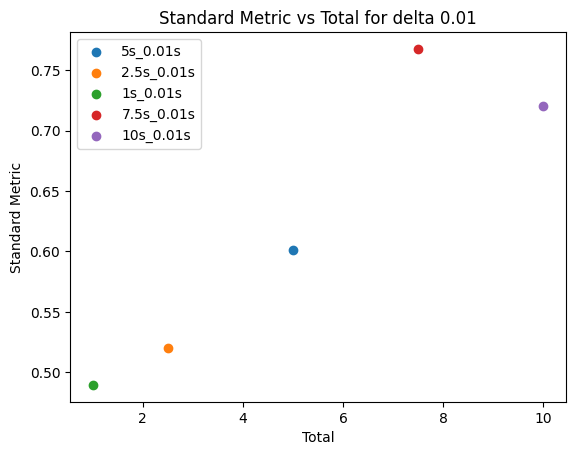

In [35]:
# plot for each of the models with delta 0.01, plot the standard metric vs the total
plt.figure()
for index, row in results_df.iterrows():
    if row['delta'] == 0.01:
        plt.scatter(row['total'], row['standard_metric_98th'], label=row['model_name'])
plt.xlabel('Total')
plt.ylabel('Standard Metric')
plt.title('Standard Metric vs Total for delta 0.01')
plt.legend()
plt.show()


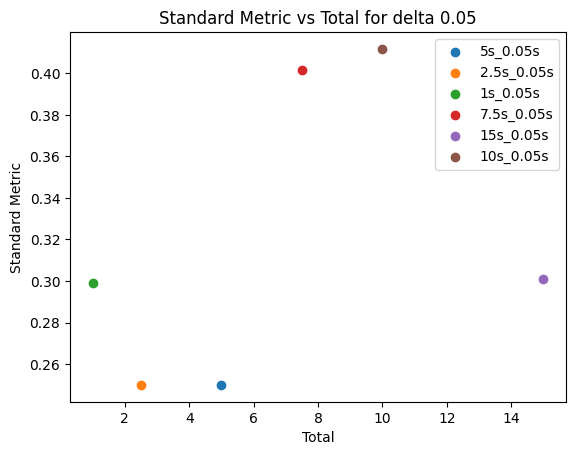

In [36]:
# plot for each of the models with delta 0.05, plot the standard metric vs the total
plt.figure()
for index, row in results_df.iterrows():
    if row['delta'] == 0.05:
        plt.scatter(row['total'], row['standard_metric'], label=row['model_name'])
plt.xlabel('Total')
plt.ylabel('Standard Metric')
plt.title('Standard Metric vs Total for delta 0.05')
plt.legend()


In [37]:
# filter the dataframe to only include models with total 5
results_df_total_5 = results_df[results_df['total'] == 5]

# get the row with the maximum standard metric
max_standard_metric_row = results_df_total_5.loc[results_df_total_5['standard_metric'].idxmax()]

max_standard_metric_row

model_name                        5s_0.01s
total                                  5.0
delta                                 0.01
slope                             0.687213
correlation_coef                   0.39293
standard_metric                    0.33386
avg_abs_error                    28.681581
avg_abs_error_normalized          1.888338
median_abs_error                   1.78178
median_abs_error_normalized       0.599003
98th_abs_error                   370.96485
98th_avg_abs_error               15.088804
98th_abs_error_normalized        13.162687
98th_avg_abs_error_normalized    15.088804
slope_98th                        0.612445
correlation_coef_98th              0.74399
standard_metric_98th                0.6013
Name: 2, dtype: object

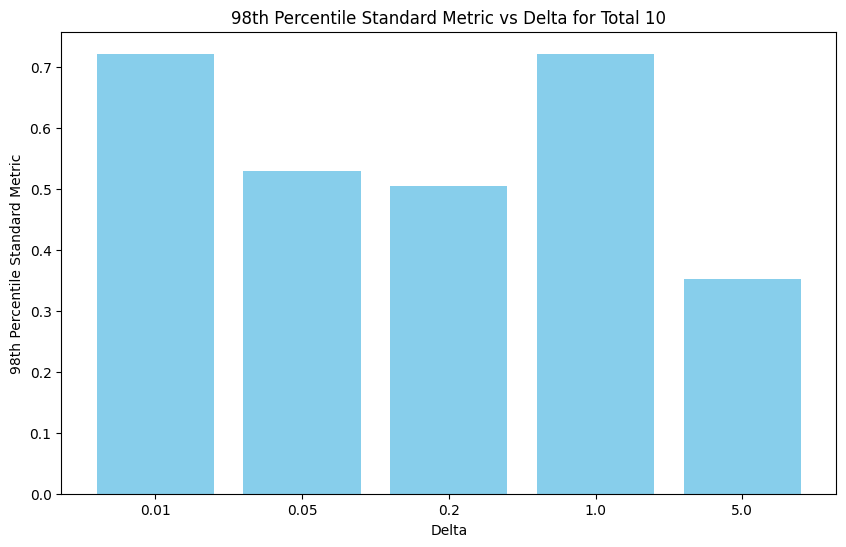

In [38]:
# Filter and sort the DataFrame by 'delta'
subset = results_df[results_df['total'] == 10].sort_values(by='delta')

# Extract the sorted values
deltas = subset['delta'].astype(str)
standard_metrics = subset['standard_metric_98th']

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(deltas, standard_metrics, color='skyblue')

# Set the x-axis and y-axis labels and title
plt.xlabel('Delta')
plt.ylabel('98th Percentile Standard Metric')
plt.title('98th Percentile Standard Metric vs Delta for Total 10')

# Show the plot without a legend
plt.show()

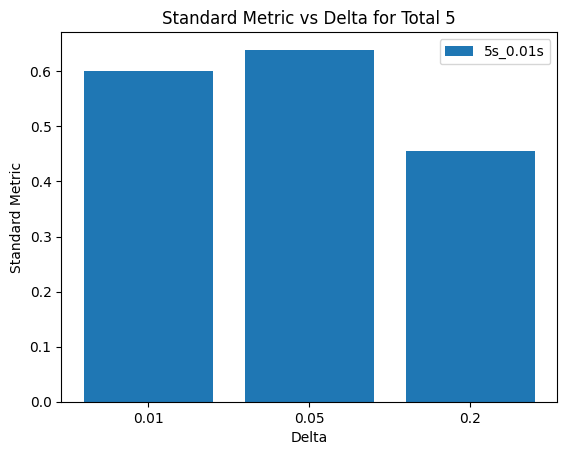

In [39]:
# Filter and sort the DataFrame by 'delta'
subset = results_df[results_df['total'] == 5].sort_values(by='delta')

# Extract the sorted values
deltas = subset['delta'].astype(str)
standard_metrics = subset['standard_metric_98th']
model_names = subset['model_name']

# Create the bar graph
plt.figure()
plt.bar(deltas, standard_metrics)

# Set the x-axis and y-axis labels and title
plt.xlabel('Delta')
plt.ylabel('Standard Metric')
plt.title('Standard Metric vs Delta for Total 5')

# Add a legend
plt.legend(model_names, loc='best')

# Show the plot
plt.show()

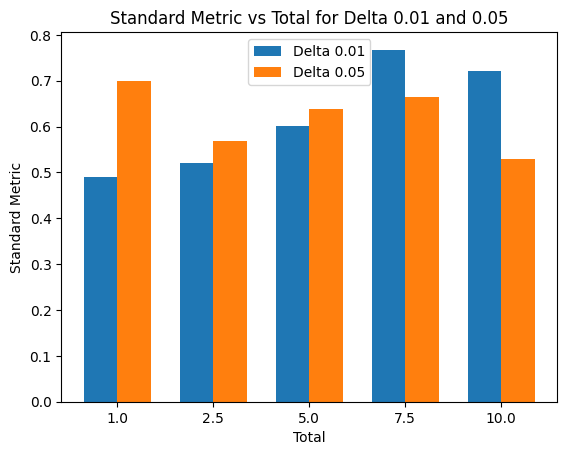

In [40]:
# Filter the DataFrame by 'delta' values
subset_0_01 = results_df[results_df['delta'] == 0.01][['total', 'standard_metric_98th']].rename(columns={'standard_metric_98th': 'metric_0_01'})
subset_0_05 = results_df[results_df['delta'] == 0.05][['total', 'standard_metric_98th']].rename(columns={'standard_metric_98th': 'metric_0_05'})

# Merge the subsets on 'total'
merged_df = pd.merge(subset_0_01, subset_0_05, on='total').sort_values(by='total')

# Extract the sorted values
totals = merged_df['total'].astype(str)
standard_metrics_0_01 = merged_df['metric_0_01']
standard_metrics_0_05 = merged_df['metric_0_05']

# Create the bar graph
plt.figure()

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(totals))

# Plot bars for delta 0.01 and 0.05
plt.bar(index, standard_metrics_0_01, bar_width, label='Delta 0.01')
plt.bar(index + bar_width, standard_metrics_0_05, bar_width, label='Delta 0.05')

# Set the x-axis and y-axis labels and title
plt.xlabel('Total')
plt.ylabel('Standard Metric')
plt.title('Standard Metric vs Total for Delta 0.01 and 0.05')

# Set the x-ticks and labels
plt.xticks(index + bar_width / 2, totals)

# Add a legend
plt.legend(loc='best')

# Show the plot
plt.show()

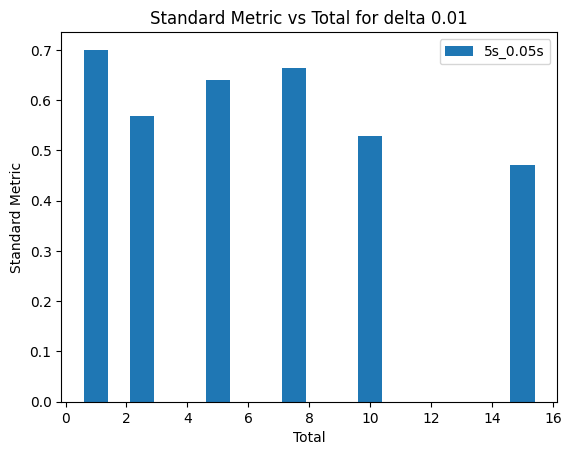

In [41]:
plt.figure()

# Filter the DataFrame by delta 0.01
subset = results_df[results_df['delta'] == 0.05]

# Extract the total and standard metric values
totals = subset['total']
standard_metrics = subset['standard_metric_98th']
model_names = subset['model_name']

# Create the bar graph
plt.bar(totals, standard_metrics)

# Set the x-axis and y-axis labels and title
plt.xlabel('Total')
plt.ylabel('Standard Metric')
plt.title('Standard Metric vs Total for delta 0.01')

# Add a legend
plt.legend(model_names, loc='best')

# Show the plot
plt.show()


In [42]:
# get the row for 7.5s_0.01s
results_df[(results_df['total'] == 7.5) & (results_df['delta'] == 0.01)]

,model_name,total,delta,slope,correlation_coef,standard_metric,avg_abs_error,avg_abs_error_normalized,median_abs_error,median_abs_error_normalized,98th_abs_error,98th_avg_abs_error,98th_abs_error_normalized,98th_avg_abs_error_normalized,slope_98th,correlation_coef_98th,standard_metric_98th
14,7.5s_0.01s,7.5,0.01,0.952425,0.606707,0.593998,23.601318,3.3509,2.36745,0.687574,326.556734,13.130545,21.507987,13.130545,0.79974,0.845877,0.767641


### Have a model that can predict the result of a speedtest based on 7.5 seconds of data with a median error of 2.37 Mbps or a median error of 68.8%, with 98th percentile average is 13.13% This model scores 59.3% on the standard metric and a 78.8% on the 98th percentile standard metric! For the 98th percentile metric, the model has slope of 0.8 and correlation coeff of 0.846 showing that the model tends to under guess.